In [1]:
import random
import warnings
import argparse
import shutil
import scipy as sp

import torch
import torch.backends.cudnn as cudnn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

import clip

from utils import CompleteLogger, TensorboardWriter
from engine import GeneralMovingAverage, get_dataset, get_text_features, pmt_train, evaluate_all_pmt
from PMT.pmt import CustomCLIP

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

import yacs.config as CN
import yaml

In [2]:
import argparse

parser = argparse.ArgumentParser(description='Baseline for Domain Generalization')
# dataset parameters
parser.add_argument('root', metavar='DIR', help='root path of dataset')
parser.add_argument('-d', '--data', metavar='DATA', default='DomainNet')
parser.add_argument('-s', '--source', metavar='SOURCE', default='PACS')
parser.add_argument('--task', default='domain_shift', choices=['domain_shift', 'open_class', 'in_the_wild'])
parser.add_argument('--targets', nargs='+', type=int, default=None, help='target domain(s) (DomainBed datasets only)')
parser.add_argument('--n-shot', type=int, default=0)
# model parameters
parser.add_argument('-a', '--arch', metavar='ARCH', default='ViT-B/16')
# training parameters
parser.add_argument('-b', '--batch-size', default=36, type=int, metavar='N', help='mini-batch size (default: 36)')
parser.add_argument('--lr', '--learning-rate', default=5e-6, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--wd', '--weight-decay', default=0.1, type=float, metavar='W', help='weight decay (default: 0.1)')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N', help='number of data loading workers (default: 4)')
parser.add_argument('--epochs', default=20, type=int, metavar='N', help='number of total epochs to run')
parser.add_argument('-i', '--iters-per-epoch', default=500, type=int, help='Number of iterations per epoch')
parser.add_argument('-p', '--print-freq', default=100, type=int, metavar='N', help='print frequency (default: 100)')
parser.add_argument('--seed', default=0, type=int, help='seed for initializing training.')
parser.add_argument('--log', type=str, default='exp0', help="Where to save logs, checkpoints and debugging images.")
parser.add_argument('--phase', type=str, default='train', choices=['train', 'test'], help="When phase is 'test', only test the model.")
# parameters for CLIPood
parser.add_argument('--temperature', type=float, default=None, help="Use CLIP's original temperature in default.")
parser.add_argument('--lam', type=float, default=0.3)
parser.add_argument('--beta', type=float, default=0.5)
parser.add_argument('--pmt_cfg_file', type=str, default='./configs/vit_b16_c16_pmt.yaml', help='Path to the pmt_cfg_file YAML file.')
parser.add_argument('--threshold', type=float, default=0.85, help='Threshold of pseudo labels.')
parser.add_argument('--debug', type=bool, default=True, help='Debug')

# 模拟命令行参数输入
args = parser.parse_args(args=[
    'DomainBed/domainbed/data/',
    '-d', 'PACS',
    '--task', 'domain_shift',
    '--targets', '0',
    '-b', '1',
    '--lr', '1e-5',
    '--epochs', '1',
    '--lam', '0.3',
    '--beta', '0.5'
])


In [3]:
from robustbench.data import load_cifar10c,load_cifar100c,load_cifar10

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

types=["gaussian_noise","shot_noise","impulse_noise","defocus_blur","glass_blur","motion_blur","zoom_blur",
       "snow","frost","fog","brightness","contrast","elastic_transform","pixelate","jpeg_compression"]

In [5]:
for type_ in types:
    x_test, y_test = load_cifar100c(10000,
                                    5, "./DomainBed/domainbed/data/cifar10c", False,
                                    [type_])

In [6]:
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
x, y=load_cifar10(50000,"./DomainBed/domainbed/data/cifar10")
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
resize_transform = transforms.Resize((224, 224))
x = resize_transform(x)
train_dataset = TensorDataset(x[:9000], y[:9000])
val_dataset = TensorDataset(x[9000:], y[9000:])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

Files already downloaded and verified


/data/wangjieyang/anaconda3/envs/vit/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [7]:
clip_model, _ = clip.load("ViT-B/16", device)
classifier = clip_model.visual
# clip.model.convert_weights(classifier)
classifier.load_state_dict(torch.load("./exp0/checkpoints/best.pth"))
classifier.eval()

VisionTransformer(
  (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): Sequential(
      (0): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): QuickGELU()
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (1): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise

In [8]:
text_features = get_text_features(clip_model, "a photo of a {}.", class_names, device)

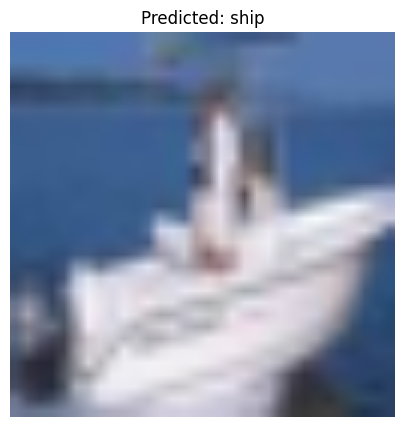

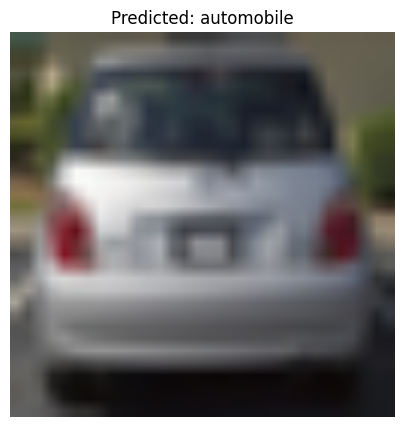

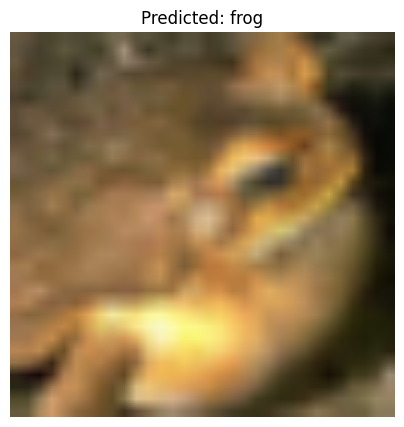

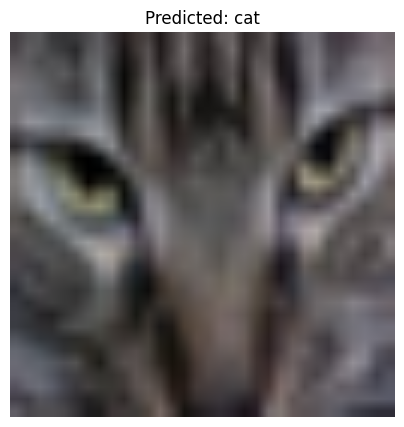

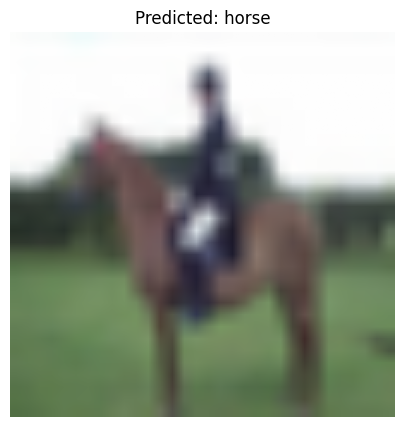

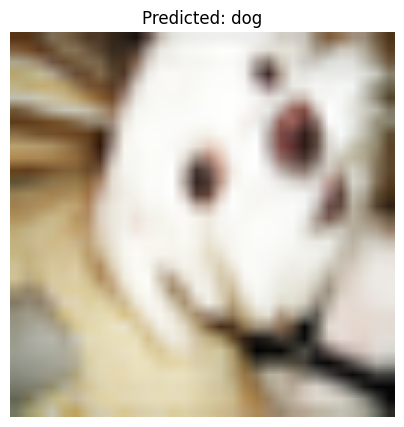

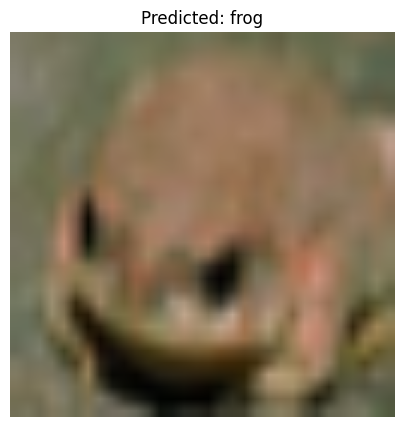

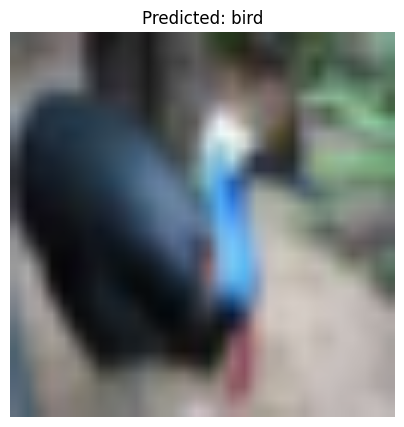

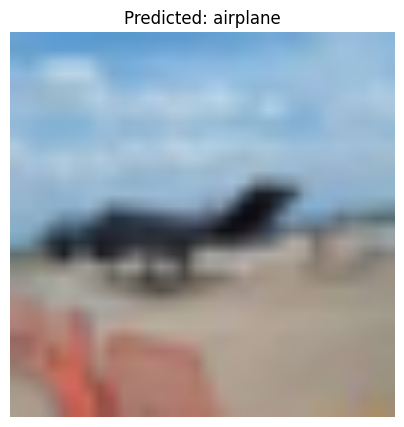

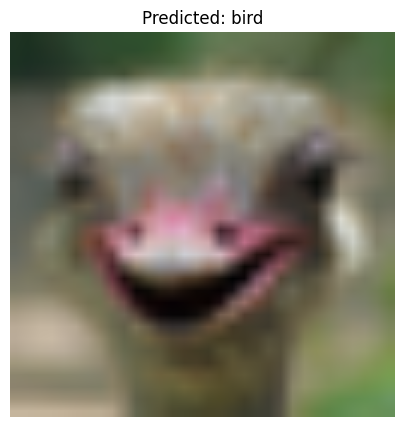

In [9]:
import matplotlib.pyplot as plt

with torch.no_grad():
    for i, (images, target) in enumerate(val_loader):
        if i >= 10:
            break
        images = images.to(device)
        target = target.to(device)

        # compute output
        image_features = classifier(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # measure accuracy and record loss
        output_similarity = image_features @ text_features.T
        predicted_index = output_similarity.argmax()

        # Draw the image before printing the class name
        plt.figure(figsize=(5, 5))
        plt.imshow(images[0].cpu().permute(1, 2, 0))  # Adjust the permute depending on your data format
        plt.title(f"Predicted: {class_names[predicted_index]}")
        plt.axis('off')
        plt.show()

        # print(class_names[predicted_index])
